### Reference
[Geolocation clustering a Paris Vacation](https://towardsdatascience.com/using-unsupervised-learning-to-plan-a-paris-vacation-geo-location-clustering-d0337b4210de): used K-Means and recommended HDBSCAN  
[KMeans Clustering of Geolocation](https://www.kaggle.com/xxing9703/kmean-clustering-of-latitude-and-longitude#)

In [280]:
import requests, json # for getting data
from urllib.parse import urlencode
from time import sleep
from datetime import datetime

import pandas as pd
import numpy as np

In [42]:
fname = 'data/centadata_clean.csv'
data = pd.read_csv( fname, index_col = 0 )

In [43]:
addresses = data['buildingaddress'].unique()

In [56]:
print( f'There are {"{:,}".format(len(addresses))} building addresses to lookup.')
geo_dict = { key : '' for key in addresses}

There are 9,496 building addresses to lookup.


In [90]:
def geocode( in_address, giveLatLon = True):
    url = "https://www.als.ogcio.gov.hk/lookup"
    headers = { 'Accept': 'application/json'}
    params = {
        "q": in_address,
        'n': 1
    }
    data = requests.post(url, headers = headers, data = params)
    
    if data.status_code == 200:
        djson = json.loads( data.text )
        
        try:
            geodata = djson['SuggestedAddress'][0]['Address']['PremisesAddress']['GeospatialInformation'][0]
        except KeyError:
            # no likely no SuggestedAddress
            return None
        
        if giveLatLon:
            return ( float(geodata['Latitude']), float(geodata['Longitude']))
        else:
            geodata
    else:
        return None

In [47]:
# ----------------------------
# ref: https://gist.github.com/vladignatyev/06860ec2040cb497f0f3
# ----------------------------
import sys

def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [162]:
def BuildGeoDict( geo_dict , tmp_fname = None ):
    counter = 0

    for addr in geo_dict:
        if geo_dict[ addr ] == '':
            try:
                counter += 1
                igcode = geocode( addr)
                if igcode:
                    geo_dict[addr] = igcode

                if counter % 50 == 0:
                    # take a break every 50 address
                    progress( counter, len(geo_dict), status = 'Geocoding Building Addresses')
                    rest_s = np.random.randint(1,5)
                    sleep( rest_s)
                    
                    # make a backup
                    if tmp_fname != None:
                        with open( tmp_fname, 'w') as outfile:
                            json.dump(geo_dict, outfile)

            except ValueError:    # this will catch all exceptions
                print(f'Unexpected error coding {addr}: {sys.exc_info()[0]}\nContinuing with next address...')
        else:
            pass
    
    progress( 100, 100, status = 'Geocoding Completed.')
    print( f'Fetched {counter} buildings geocodes and written temporary json data to {tmp_fname}')
    return geo_dict

*Legacy*: read data from CSV

In [163]:
fname_csv = 'data/building_geocode.csv'
tmp_fname = 'data/tmp_building_geocode.json'
df_tmp = pd.read_csv( fname_csv, index_col = 0)

df_tmp['latlon'] = df_tmp.apply( lambda x: '' if np.isnan(x.Lat) else (x.Lat, x.Lon),axis =1)
addr_geo_dict = { key : latlon for key, latlon in zip( df_tmp.index, df_tmp.latlon ) }

fname_json = 'data/building_geocode.json'
with open( fname_json, 'w') as fh:
    json.dump( addr_geo_dict, fh)

Load what we already have in `data/building_geocode.json` and finish getting geocode,  
write the output in the end back to the json file

In [164]:
fname_json = 'data/building_geocode.json'
tmp_fname = 'data/tmp_building_geocode.json'

with open(fname_json, 'r') as fh:
    jdata = fh.read()
addr_geo_dict = json.loads(jdata)

out_dict = BuildGeoDict( addr_geo_dict, tmp_fname = tmp_fname)
with open( fname_json, 'w') as fh:
    json.dump( out_dict, fh)

Load the JSON back into a Dataframe for use

In [187]:
clean_dict = {key : tuple( out_dict[key]) for key in out_dict}
df_geo = pd.DataFrame.from_dict(clean_dict, orient = 'index', columns = ['Lat', 'Lon'])

missing_addr = df_geo[ df_geo.Lat.isna()]
print(f'There are {len(missing_addr)} buildings missing geocode.')

missing_addr.head()

There are 19 buildings missing geocode.


,Lat,Lon
"21 FAIRVIEW PARK SECTION C, 6TH STREET",NaN,NaN
"11 FAIRVIEW PARK SECTION C, 6TH STREET",NaN,NaN
"16 FAIRVIEW PARK SECTION B, 6TH STREET",NaN,NaN
"3 FAIRVIEW PARK SECTION C, 1ST STREET",NaN,NaN
"7 FAIRVIEW PARK SECTION C, 1ST STREET",NaN,NaN


Let's manually geocode these few missing geocode

In [220]:
import re
def manualGeo( addr ):
    m = re.search(r'(.+)SECTION', addr)
    if m is None:
        return None
    else:
        new_addr = m.group(1)
        return geocode(new_addr)

df_bgeo = df_geo.reset_index().rename(columns = {'index': 'building_address'})
df_bgeo['latlon'] = df_bgeo.apply(
     lambda x: manualGeo( x.building_address ) if np.isnan(x.Lat) else (x.Lat, x.Lon), axis=1)

#df_bgeo.at[df_bgeo.Lat.isna(),['Lat']] = df_bgeo[df_geo.Lat.isna()]['building_address'].apply( manualGeo)

In [222]:
df_bgeo.iloc[7515:,:].head(10)

,building_address,Lat,Lon,latlon
7515,"21 FAIRVIEW PARK SECTION C, 6TH STREET",NaN,NaN,"(22.479, 114.0508)"
7516,"11 FAIRVIEW PARK SECTION C, 6TH STREET",NaN,NaN,"(22.4807, 114.0508)"
7517,"16 FAIRVIEW PARK SECTION B, 6TH STREET",NaN,NaN,"(22.4796, 114.0504)"
7518,"3 FAIRVIEW PARK SECTION C, 1ST STREET",NaN,NaN,"(22.4849, 114.0445)"
7519,"36 FAIRVIEW PARK SECTION B, 4TH STREET",22.2250,114.1120,"(22.225, 114.112)"
7520,"23 FAIRVIEW PARK SECTION C, 3RD STREET",22.2040,114.0323,"(22.204, 114.0323)"
7521,"7 FAIRVIEW PARK SECTION C, 1ST STREET",NaN,NaN,"(22.4746, 114.043)"
7522,"31 FAIRVIEW PARK SECTION C, 4TH STREET",22.4652,114.1425,"(22.4652, 114.1425)"
7523,"2 FAIRVIEW PARK SECTION B, 1ST STREET",NaN,NaN,"(22.485, 114.0444)"
7524,"14 FAIRVIEW PARK SECTION C, 6TH STREET",NaN,NaN,"(22.4795, 114.0503)"


In [298]:
for addr in clean_dict:
    if clean_dict[addr] == ():
        clean_dict[addr] = manualGeo(addr)
        
data['latlon'] = data.buildingaddress.apply( lambda x: clean_dict[x])

In [299]:
data.head()

,txdate,price,saleablearea,xaxis,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,...,price_per_sqf,flat_type,floor_number,building_age,deal_age,deal_year,schoolnet_en,latlon,adj_price_per_sqf,haslatlon
0,2017-02-16,2880000,392.0,NO. 205A,2/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,...,7346.938776,n,2,55.301848,641,2017,Kowloon district No. 32 school network,"(22.3231, 114.1696)",8991.196804,True
1,2018-01-11,3000000,392.0,NO. 205A,3/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,...,7653.061224,n,3,55.301848,312,2018,Kowloon district No. 32 school network,"(22.3231, 114.1696)",8261.302969,True
2,2017-06-26,51000000,1912.0,NO. 4B,5/F,4A-4B WONG NAI CHUNG GAP ROAD,1965-09-01,8,8,1,...,26673.640167,n,5,53.215606,511,2017,Hong Kong District No. 12 school network,"(22.2629, 114.1854)",30122.817775,True
3,2018-03-21,4150000,294.0,FLAT B,16/F,98 TSEUK LUK STREET,1999-01-01,30,15,2,...,14115.646259,n,16,19.882272,243,2018,Kowloon district No. 43 school network,"(22.335, 114.1975)",14725.757578,True
4,2017-11-28,5250000,530.0,FLAT B,8/F,54-58 SOUTH WALL ROAD,1969-10-01,32,9,4,...,9905.660377,n,8,49.133470,356,2017,Kowloon district No. 41 school network,"(22.3298, 114.1911)",10919.178555,True


### Let's build a model

for our model we will just be concerned with the **small/ medium units**, and excluding all ab-normal `flat_type`

In [274]:
cci_data = pd.read_csv('data/cci_small_medium_2017_2018.csv', header = None, names = ['Date', 'CCI'])
cci_data['idx_date'] = cci_data['Date'].apply( lambda x: x.split(" - ")[0])

cci_data.idx_date = cci_data.idx_date.astype('datetime64')
data.txdate = data.txdate.astype('datetime64')

cci_data.head()

,Date,CCI,idx_date
0,2018/11/05 - 2018/11/11,180.78,2018-11-05
1,2018/10/29 - 2018/11/04,183.32,2018-10-29
2,2018/10/22 - 2018/10/28,184.49,2018-10-22
3,2018/10/15 - 2018/10/21,185.66,2018-10-15
4,2018/10/08 - 2018/10/14,186.00,2018-10-08


In [271]:
def GetCCI(inDate):
    dfilter = (cci_data.idx_date <= inDate) 
    return cci_data[dfilter]['CCI'].iloc[0]

#GetCCI( data.txdate[1])

167.47

In [281]:
data['adj_price_per_sqf'] = data.apply( lambda x: x.price_per_sqf * GetCCI(datetime.today())/ GetCCI(x.txdate) , axis = 1)
data.head()

,txdate,price,saleablearea,xaxis,yaxis,buildingaddress,dateofcompletion,numberofunits,numberoffloors,flatsperfloor,...,region,price_per_sqf,flat_type,floor_number,building_age,deal_age,deal_year,schoolnet_en,latlon,adj_price_per_sqf
0,2017-02-16,2880000,392.0,NO. 205A,2/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,...,Mongkok/Yaumatei,7346.938776,n,2,55.301848,641,2017,Kowloon district No. 32 school network,"(22.3231, 114.1696)",8991.196804
1,2018-01-11,3000000,392.0,NO. 205A,3/F,205A TUNG CHOI STREET,1963-08-01,8,8,1,...,Mongkok/Yaumatei,7653.061224,n,3,55.301848,312,2018,Kowloon district No. 32 school network,"(22.3231, 114.1696)",8261.302969
2,2017-06-26,51000000,1912.0,NO. 4B,5/F,4A-4B WONG NAI CHUNG GAP ROAD,1965-09-01,8,8,1,...,Happy Valley/Mid Level East,26673.640167,n,5,53.215606,511,2017,Hong Kong District No. 12 school network,"(22.2629, 114.1854)",30122.817775
3,2018-03-21,4150000,294.0,FLAT B,16/F,98 TSEUK LUK STREET,1999-01-01,30,15,2,...,Diamond Hill/Wong Tai Sin,14115.646259,n,16,19.882272,243,2018,Kowloon district No. 43 school network,"(22.335, 114.1975)",14725.757578
4,2017-11-28,5250000,530.0,FLAT B,8/F,54-58 SOUTH WALL ROAD,1969-10-01,32,9,4,...,Diamond Hill/Wong Tai Sin,9905.660377,n,8,49.133470,356,2017,Kowloon district No. 41 school network,"(22.3298, 114.1911)",10919.178555


In [305]:
l_mod_col = ['lat','lon', 'adj_price_per_sqf']

data['lat'] = data.latlon.apply( lambda x: x[0])
data['lon'] = data.latlon.apply( lambda x: x[1])

size_filter = data.saleablearea <= 1076
flat_type_filter = data.flat_type == 'n'

df_cluster = data[size_filter & flat_type_filter]
df_model = df_cluster[l_mod_col]

#### Machine Learning Prelimary

In [307]:
from sklearn.cluster import KMeans

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

since there's 56 region in the original dataset, we will use that as the starting point

In [306]:
k_means = KMeans( n_clusters= 56, random_state= 420)
k_means.fit( df_model )
df_cluster['cluster'] = k_means.predict( df_model)

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'sns' is not defined

<Figure size 2160x2880 with 0 Axes>

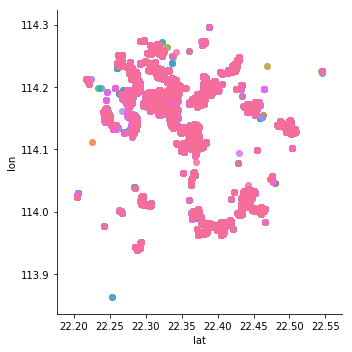

In [314]:
plt.figure(figsize = (30,40))

sns.lmplot(x = 'lat', y='lon', hue = 'cluster', data = df_cluster, fit_reg = False, legend = False)

Looks like 56 clusters are a bit over kill, let's see what's the optimal number of clusters according to the elblow method

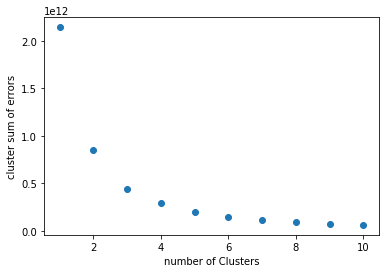

In [313]:
wcss = [] # within-cluster sum of errors

for i in range(1, 11):
    k_means = KMeans( n_clusters = i, random_state = 420)
    k_means.fit( df_model )
    wcss.append( k_means.inertia_)

plt.scatter(x = range(1,11), y = wcss) 
plt.xlabel('number of Clusters')
plt.ylabel('cluster sum of errors');

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 2160x2880 with 0 Axes>

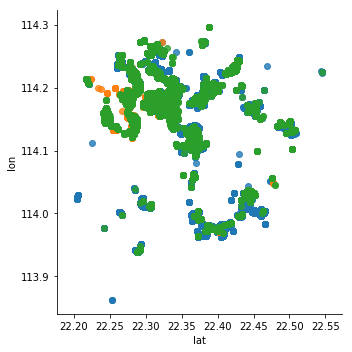

In [315]:
k_means = KMeans( n_clusters = 3, random_state = 420)
k_means.fit( df_model )
df_cluster['cluster'] = k_means.predict( df_model)
plt.figure(figsize = (30,40))

sns.lmplot(x = 'lat', y='lon', hue = 'cluster', data = df_cluster, fit_reg = False, legend = False)

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 2160x2880 with 0 Axes>

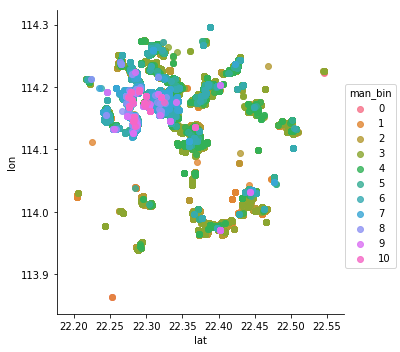

In [322]:
manual_cluster_dict = {5000: 1,
                      10000: 2,
                      12000: 3,
                      15000: 4,
                      18000: 5,
                      20000: 6,
                      25000: 7,
                      30000: 8,
                      35000: 9,
                      40000: 10}
def mapPrice(inPrice):
    cluster = 0
    for i in manual_cluster_dict:
        if inPrice >= i:
            cluster = manual_cluster_dict[i]
    return cluster

df_cluster['man_bin'] = df_cluster.adj_price_per_sqf.apply(mapPrice)

plt.figure(figsize = (30,40))
sns.lmplot(x = 'lat', y='lon', hue = 'man_bin', data = df_cluster, fit_reg = False, legend = True)

/Users/JHO/.virtualenvs/accelerateHK3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Model score compare to manual price bining: 0.5286866675374277


<Figure size 2160x2880 with 0 Axes>

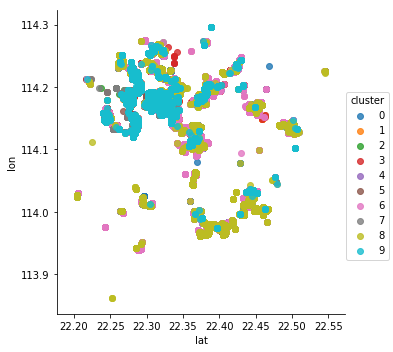

In [331]:
df_model = df_cluster[['lat', 'lon', 'adj_price_per_sqf']]
k_means = KMeans( n_clusters = 10, random_state = 420)
k_means.fit( df_model )
df_cluster['cluster'] = k_means.predict( df_model)

from sklearn.metrics import adjusted_rand_score
cluster_score = adjusted_rand_score(df_cluster.cluster, df_cluster.man_bin)
print( f'Model score compare to manual price bining: {cluster_score}')

plt.figure(figsize = (30,40))
sns.lmplot(x = 'lat', y='lon', hue = 'cluster', data = df_cluster, fit_reg = False, legend = True)